In [24]:
import os
import glob
import time
from datetime import datetime

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import plotly.graph_objs as go

import MetaTrader5 as mt5
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import config

In [20]:
df_f = pd.read_feather("financial_data.feather")

In [21]:
pd.set_option('display.max_rows', None)

In [22]:
pd.set_option('display.max_columns', None)
df_f

,Start Date,Account Size,Equity,Status,Profit Target,Daily Loss,Maximum Loss,Absolute Losses,percentage of daily loss,Percentage of Losses,Absolute Profits,percentage of daily profit,Percentage of Profits,Percentage of Average Win,Percentage of Average Loss,Absolute daily loss,Absolute Daily Profit,Daily Loss Time Difference (days),Active Trading Days,Number of Trades,Winrate,Average Win,Average Loss,Platform,Server,Total Lots Traded,Max Permitted Losses,Today's Permitted Loss,commission
0,2023-11-30 11:18:27,10000.0,9117.84,Red,6%,2%,6%,"$1,378.24",3.02%,15.12%,$744.92,1.63%,8.17%,4.91%,1.26%,$279.41,$151.02,5,2,36,0.666667,447.705,-114.853333,MetaTrader 5,Alpari-MT5-Demo,53.01,6.0,1.823568,-124.42


In [17]:
df_f = pd.read_feather("history_deals_df.feather")
pd.set_option('display.max_rows', None)
df_f.head()

,ticket,order,time,time_msc,type,entry,magic,position_id,reason,volume,price,commission,swap,profit,fee,symbol,comment,external_id
0,156509592,0,2023-11-30 11:18:27,1701343107010,2,0,0,0,0,0.0,0.000,0.0,0.0,10000.0,0.0,,,
1,156509735,189649925,2023-11-30 11:19:51,1701343191789,1,0,0,189649925,0,1.0,147.076,-1.6,0.0,0.0,0.0,USDJPY,,
2,156509740,189649931,2023-11-30 11:19:53,1701343193536,0,0,0,189649931,0,1.0,147.082,-1.6,0.0,0.0,0.0,USDJPY,,
3,156509742,189649933,2023-11-30 11:19:54,1701343194260,1,0,0,189649933,0,1.0,147.075,-1.6,0.0,0.0,0.0,USDJPY,,
4,156509743,189649934,2023-11-30 11:19:54,1701343194914,1,0,0,189649934,0,1.0,147.075,-1.6,0.0,0.0,0.0,USDJPY,,


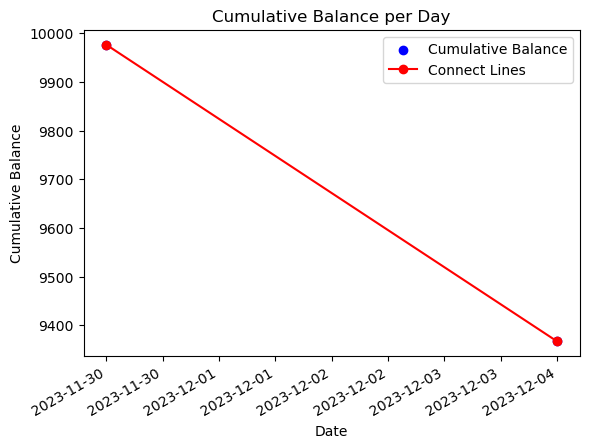

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

mean_daily_profit = df_f.groupby(df_f['time'].dt.date)['profit'].mean()

# Create a new column for cumulative balance
df_f['cumulative_balance'] = df_f['profit'].cumsum()   # Assuming the starting balance is 10000

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(mean_daily_profit.index, df_f.groupby(df_f['time'].dt.date)['cumulative_balance'].last().values, label='Cumulative Balance', color='blue')

# Connect points with lines
ax.plot(mean_daily_profit.index, df_f.groupby(df_f['time'].dt.date)['cumulative_balance'].last().values, linestyle='-', marker='o', color='red', label='Connect Lines')

# Set the date format for the x-axis ticks
date_format = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)

# Ensure a readable date rotation
fig.autofmt_xdate()

plt.title('Cumulative Balance per Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Balance')
plt.legend()
plt.show()

In [29]:
# Calculate absolute values for clarity in the pie chart
df_f['Absolute Win'] = df_f['Average Win'].abs()
df_f['Absolute Loss'] = df_f['Average Loss'].abs()

# Round up the values
df_f['Absolute Win Rounded'] = np.ceil(df_f['Absolute Win'])
df_f['Absolute Loss Rounded'] = np.ceil(df_f['Absolute Loss'])

# Create a Pie chart
fig = go.Figure(data=[go.Pie(labels=['Average Win', 'Average Loss'], 
                             values=[df_f['Absolute Win Rounded'].iloc[0], df_f['Absolute Loss Rounded'].iloc[0]],
                             hole=0.7,
                             pull=[0, 0.1],  # Pull the 'Average Loss' slice slightly for emphasis
                             textinfo='value+percent',
                             marker=dict(colors=['green', 'red']))])

# Customize layout
fig.update_layout(title='Average Win vs Average Loss',
                  margin=dict(l=0, r=0, b=0, t=40),
                  annotations=[dict(text='Win', x=0.5, y=0.5, font_size=20, showarrow=False)])

# Show the plot
fig.show()

In [20]:
print(df_f['Percentage of Losses'])
print(df_f["Maximum Loss"])

0    15.12%
Name: Percentage of Losses, dtype: object
0    6%
Name: Maximum Loss, dtype: object


In [1]:
account = 51913983
password = "drbj2iln"
server = "Alpari-MT5-Demo"

In [4]:
mt5.initialize()
authorized=mt5.login(account, password=password, server=server)
pd. set_option('display.max_columns', None) 

In [5]:
account_info_dict = mt5.account_info()._asdict()
account_info_df = pd.DataFrame(account_info_dict, index=[0])

In [70]:
account_info_df

,login,trade_mode,leverage,limit_orders,margin_so_mode,trade_allowed,trade_expert,margin_mode,currency_digits,fifo_close,balance,credit,profit,equity,margin,margin_free,margin_level,margin_so_call,margin_so_so,margin_initial,margin_maintenance,assets,liabilities,commission_blocked,name,server,currency,company
0,51913983,0,100,10000,0,True,True,2,2,False,9117.84,0.0,0.0,9117.84,0.0,9117.84,0.0,80.0,60.0,0.0,0.0,0.0,0.0,0.0,vatche thorossian,Alpari-MT5-Demo,USD,Alpari


In [71]:
print("Profit:", account_info_df["profit"].iloc[0])
print("Equity:", account_info_df["equity"].iloc[0])
print("Margin:", account_info_df["margin"].iloc[0])
print("Margin Free:", account_info_df["margin_free"].iloc[0])

Profit: 0.0
Equity: 9117.84
Margin: 0.0
Margin Free: 9117.84


In [14]:
from_date=datetime(2020,1,1)
to_date=datetime.now()
history_data=(mt5.history_orders_get(from_date, to_date))

In [20]:
trade_data_dataframe=pd.DataFrame(list(history_data),columns=history_data[0]._asdict().keys())


In [21]:
trade_data_dataframe.head()

,ticket,time_setup,time_setup_msc,time_done,time_done_msc,time_expiration,type,type_time,type_filling,state,magic,position_id,position_by_id,reason,volume_initial,volume_current,price_open,sl,tp,price_current,price_stoplimit,symbol,comment,external_id
0,189649925,1701343191,1701343191743,1701343191,1701343191789,0,1,0,0,4,0,189649925,0,0,1.0,0.0,0.0,0.0,0.0,147.076,0.0,USDJPY,,
1,189649931,1701343193,1701343193481,1701343193,1701343193536,0,0,0,0,4,0,189649931,0,0,1.0,0.0,0.0,0.0,0.0,147.082,0.0,USDJPY,,
2,189649933,1701343194,1701343194186,1701343194,1701343194260,0,1,0,0,4,0,189649933,0,0,1.0,0.0,0.0,0.0,0.0,147.075,0.0,USDJPY,,
3,189649934,1701343194,1701343194863,1701343194,1701343194914,0,1,0,0,4,0,189649934,0,0,1.0,0.0,0.0,0.0,0.0,147.075,0.0,USDJPY,,
4,189649985,1701343212,1701343212008,1701343212,1701343212067,0,0,0,0,4,0,189649985,0,0,1.0,0.0,0.0,0.0,0.0,147.088,0.0,USDJPY,,


In [64]:
deals=mt5.history_deals_get(from_date, to_date, group="*USD*")
if deals==None:
    print("No deals with group=\"*USD*\", error code={}".format(mt5.last_error()))
elif len(deals)> 0:
    print("history_deals_get({}, {}, group=\"*GBP*\")={}".format(from_date,to_date,len(deals)))

history_deals_get(2020-12-01 00:00:00, 2023-12-04 20:31:41.588292, group="*GBP*")=26


In [65]:
deals

(TradeDeal(ticket=156509735, order=189649925, time=1701343191, time_msc=1701343191789, type=1, entry=0, magic=0, position_id=189649925, reason=0, volume=1.0, price=147.076, commission=-1.6, swap=0.0, profit=0.0, fee=0.0, symbol='USDJPY', comment='', external_id=''),
 TradeDeal(ticket=156509740, order=189649931, time=1701343193, time_msc=1701343193536, type=0, entry=0, magic=0, position_id=189649931, reason=0, volume=1.0, price=147.082, commission=-1.6, swap=0.0, profit=0.0, fee=0.0, symbol='USDJPY', comment='', external_id=''),
 TradeDeal(ticket=156509742, order=189649933, time=1701343194, time_msc=1701343194260, type=1, entry=0, magic=0, position_id=189649933, reason=0, volume=1.0, price=147.075, commission=-1.6, swap=0.0, profit=0.0, fee=0.0, symbol='USDJPY', comment='', external_id=''),
 TradeDeal(ticket=156509743, order=189649934, time=1701343194, time_msc=1701343194914, type=1, entry=0, magic=0, position_id=189649934, reason=0, volume=1.0, price=147.075, commission=-1.6, swap=0.0,

In [6]:
from_date=datetime(2020,12,1)
to_date=datetime.now()

history_deals=(mt5.history_deals_get(from_date, to_date))

In [55]:
from_date

datetime.datetime(2020, 12, 1, 0, 0)

In [54]:
to_date


datetime.datetime(2023, 12, 4, 20, 31, 41, 588292)

In [7]:
deals_dataframe=pd.DataFrame(list(history_deals),columns=history_deals[0]._asdict().keys())
deals_dataframe["time"] = pd.to_datetime(deals_dataframe["time"], unit="s")

In [8]:
deals_dataframe

,ticket,order,time,time_msc,type,entry,magic,position_id,reason,volume,price,commission,swap,profit,fee,symbol,comment,external_id
0,156509592,0,2023-11-30 11:18:27,1701343107010,2,0,0,0,0,0.0,0.00000,0.00,0.0,10000.00,0.0,,,
1,156509735,189649925,2023-11-30 11:19:51,1701343191789,1,0,0,189649925,0,1.0,147.07600,-1.60,0.0,0.00,0.0,USDJPY,,
2,156509740,189649931,2023-11-30 11:19:53,1701343193536,0,0,0,189649931,0,1.0,147.08200,-1.60,0.0,0.00,0.0,USDJPY,,
3,156509742,189649933,2023-11-30 11:19:54,1701343194260,1,0,0,189649933,0,1.0,147.07500,-1.60,0.0,0.00,0.0,USDJPY,,
4,156509743,189649934,2023-11-30 11:19:54,1701343194914,1,0,0,189649934,0,1.0,147.07500,-1.60,0.0,0.00,0.0,USDJPY,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,157033724,190193389,2023-12-04 18:48:23,1701715703451,0,1,0,190193380,0,4.0,2024.13000,-12.95,0.0,-64.00,0.0,XAUUSD,,
67,157033726,190193392,2023-12-04 18:48:24,1701715704994,0,0,0,190193392,0,4.0,2024.13000,-12.95,0.0,0.00,0.0,XAUUSD,,
68,157033750,190193418,2023-12-04 18:48:40,1701715720815,1,1,0,190193392,0,4.0,2023.66000,-12.95,0.0,-188.00,0.0,XAUUSD,,
69,157037217,190197103,2023-12-04 19:07:57,1701716877927,0,0,0,190197103,0,4.0,1.46499,-6.93,0.0,0.00,0.0,EURCAD,,


In [40]:
deals_dataframe

,ticket,order,time,time_msc,type,entry,magic,position_id,reason,volume,price,commission,swap,profit,fee,symbol,comment,external_id
0,156509592,0,1701343107,1701343107010,2,0,0,0,0,0.0,0.00000,0.00,0.0,10000.00,0.0,,,
1,156509735,189649925,1701343191,1701343191789,1,0,0,189649925,0,1.0,147.07600,-1.60,0.0,0.00,0.0,USDJPY,,
2,156509740,189649931,1701343193,1701343193536,0,0,0,189649931,0,1.0,147.08200,-1.60,0.0,0.00,0.0,USDJPY,,
3,156509742,189649933,1701343194,1701343194260,1,0,0,189649933,0,1.0,147.07500,-1.60,0.0,0.00,0.0,USDJPY,,
4,156509743,189649934,1701343194,1701343194914,1,0,0,189649934,0,1.0,147.07500,-1.60,0.0,0.00,0.0,USDJPY,,
5,156509790,189649985,1701343212,1701343212067,0,0,0,189649985,0,1.0,147.08800,-1.60,0.0,0.00,0.0,USDJPY,,
6,156509793,189649988,1701343213,1701343213788,0,0,0,189649988,0,1.0,147.08800,-1.60,0.0,0.00,0.0,USDJPY,,
7,156509894,189650095,1701343249,1701343249176,0,1,0,189649925,0,1.0,147.07300,-1.60,0.0,2.04,0.0,USDJPY,,
8,156509898,189650098,1701343251,1701343251471,0,1,0,189649933,0,1.0,147.07100,-1.60,0.0,2.72,0.0,USDJPY,,
9,156509900,189650100,1701343252,1701343252138,0,1,0,189649934,0,1.0,147.07100,-1.60,0.0,2.72,0.0,USDJPY,,


In [9]:
mt5.shutdown()

True

In [1]:
import pandas as pd
from datetime import datetime
from loguru import logger
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import MetaTrader5 as mt5


def login_to_mt5(account, password, server):
    mt5.initialize()
    authorized = mt5.login(account, password=password, server=server)

    return authorized


def get_account_info(account, password, server):
    try:
        # Logging in to MetaTrader 5
        authorized = login_to_mt5(account, password, server)

        if authorized:
            # Getting account information
            account_info_dict = mt5.account_info()._asdict()
            account_info_df = pd.DataFrame(account_info_dict, index=[0])
            name = account_info_df["name"].iloc[0]

            logger.info(f"Acoount Name: {name}")

            return account_info_df
        else:
            raise Exception("Login failed.")
    except Exception as e:
        logger.error(f"Error while getting account information: {str(e)}")
        raise e


def get_history_orders(account, password, server, from_date, to_date):
    try:
        mt5.initialize()
        authorized = mt5.login(account, password=password, server=server)

        history_data = mt5.history_orders_get(from_date, to_date)
        history_orders_df = pd.DataFrame(
            list(history_data), columns=history_data[0]._asdict().keys()
        )

        # Log the length of the DataFrame
        logger.info(f"Length of history_orders_df: {len(history_orders_df)}")

        return history_orders_df
    except Exception as e:
        logger.error(f"Error while getting history orders: {str(e)}")
        raise e


def get_history_deals(account, password, server, from_date, to_date):
    try:
        mt5.initialize()
        authorized = mt5.login(account, password=password, server=server)

        history_deals = mt5.history_deals_get(from_date, to_date)
        history_deals_df = pd.DataFrame(
            list(history_deals), columns=history_deals[0]._asdict().keys()
        )

        # Log the length of the DataFrame
        logger.info(f"Length of history_deals_df: {len(history_deals_df)}")

        return history_deals_df
    except Exception as e:
        logger.error(f"Error while getting history deals: {str(e)}")
        raise e


def determine_single_stage(
    account_size, profit_target, max_loss, daily_loss, trading_days
):
    # Conditions for Single Stage
    if (
        0 <= account_size <= 50000
        and profit_target == 0.06
        and max_loss == 0.06
        and daily_loss == 0.02
        and trading_days >= 3
    ):
        return "Single Stage"
    else:
        return None


def determine_two_stage(
    account_size,
    profit_target_stage1,
    profit_target_stage2,
    max_loss,
    daily_loss,
    trading_days,
):
    # Conditions for Two Stage
    if (
        0 <= account_size <= 50000
        and profit_target_stage1 == 0.10
        and profit_target_stage2 == 0.05
        and max_loss == 0.12
        and daily_loss == 0.05
        and trading_days >= 3
    ):
        return "Two Stage"
    else:
        return None


def determine_rocket_stage(account_size, profit_target, max_loss):
    # Conditions for Rocket Stage
    if 0 <= account_size <= 50000 and profit_target == 0.10 and max_loss == 0.05:
        return "Rocket Stage"
    else:
        return None


def calculate_metrics(account_size, stage):
    # Calculate additional metrics based on the provided conditions
    if 3000 <= account_size <= 50000 and stage == "Single Stage":
        profit_target_stage1 = 0.06
        profit_target_stage2 = None
        max_loss = 0.06
        daily_loss = 0.02
    elif 2000 <= account_size <= 20000 and stage == "Two Stage":
        profit_target_stage1 = 0.10
        profit_target_stage2 = 0.05
        max_loss = 0.12
        daily_loss = 0.05
    elif 2000 <= account_size <= 20000 and stage == "Rocket Stage":
        profit_target_stage1 = 0.10
        profit_target_stage2 = 0.05  # Different from stage 1 for two-stage
        max_loss = 0.05
        daily_loss = None  # No daily loss for the Rocket Stage
    else:
        raise ValueError("Invalid account size")

    return profit_target_stage1, profit_target_stage2, max_loss, daily_loss


def determine_status(
    profit_target_stage1,
    profit_target_stage2,
    max_loss,
    daily_loss,
    trading_days,
    stage,
):
    # Determine status based on the stage
    red_causes = []

    if stage == "Single Stage":
        if not (
            profit_target_stage1 >= 0.06
            and profit_target_stage2 is None
            and max_loss <= 0.06
            and daily_loss < 0.02
            and trading_days >= 3
        ):
            red_causes.append(
                {
                    "Condition": "Single Stage",
                    "Max Loss": max_loss,
                    "Profit Target Stage 1": profit_target_stage1,
                }
            )
    elif stage == "Two Stage":
        if not (
            profit_target_stage1 >= 0.10
            and profit_target_stage2 >= 0.05
            and max_loss < 0.12
            and daily_loss < 0.05
            and trading_days >= 3
        ):
            red_causes.append(
                {
                    "Condition": "Two Stage",
                    "Max Loss": max_loss,
                    "Profit Target Stage 1": profit_target_stage1,
                    "Profit Target Stage 2": profit_target_stage2,
                }
            )
    elif stage == "Rocket Stage":
        if not (profit_target_stage1 == 0.10 and max_loss == 0.05):
            red_causes.append(
                {
                    "Condition": "Rocket Stage",
                    "Max Loss": max_loss,
                    "Profit Target Stage 1": profit_target_stage1,
                }
            )
    else:
        red_causes.append({"Condition": "N/A"})

    return "Red" if red_causes else "Green", red_causes


def generate_final_data(account_info_df, deals_dataframe, trading_days, stage):
    # Extracting relevant information from 'deals_dataframe'
    start_date = deals_dataframe["time"].iloc[0]
    number_of_trades = len(deals_dataframe)
    win_rate = (
        ((deals_dataframe["profit"] > 0).sum() / number_of_trades)
        if number_of_trades > 0
        else 0
    )
    average_win = deals_dataframe[deals_dataframe["profit"] > 0]["profit"].mean()
    average_loss = deals_dataframe[deals_dataframe["profit"] < 0]["profit"].mean()
    
    # Calculate absolute values of losses and profits
    absolute_losses = -deals_dataframe[deals_dataframe["profit"] < 0]["profit"].sum()
    absolute_profits = deals_dataframe[deals_dataframe["profit"] > 0]["profit"].sum()

    # Calculate percentages
    percentage_of_losses = (absolute_losses / account_info_df["equity"].iloc[0]) * 100
    percentage_of_profits = (absolute_profits / account_info_df["equity"].iloc[0]) * 100

    # Calculate percentage of average win and average loss
    percentage_of_average_win = (average_win / account_info_df["equity"].iloc[0]) * 100
    percentage_of_average_loss = (abs(average_loss) / account_info_df["equity"].iloc[0]) * 100


    # Calculating additional metrics based on account size
    account_size = account_info_df["balance"].iloc[0]
    (
        profit_target_stage1,
        profit_target_stage2,
        max_loss,
        daily_loss,
    ) = calculate_metrics(account_size, stage)

    # Determine the status
    status, red_causes = determine_status(
        profit_target_stage1,
        profit_target_stage2,
        max_loss,
        daily_loss,
        trading_days,
        stage,
    )
    logger.info(f"Red Causes: {red_causes}")
    # Creating the final dataframe

    financial_data = pd.DataFrame(
        {
            "Start Date": [start_date],
            "Account Size": [account_size],
            "Equity": [account_info_df["equity"].iloc[0]],
            "Status": [status],
            "Profit Target": [
                f"{format(profit_target_stage1 * 100, '.2f').rstrip('0').rstrip('.')}%".lstrip(
                    "0"
                )
                if stage != "Rocket Stage"
                else f"{format(profit_target_stage2 * 100, '.2f').rstrip('0').rstrip('.')}%".lstrip(
                    "0"
                )
            ],
            "Daily Loss": [
                f"{format(daily_loss * 100, '.2f').rstrip('0').rstrip('.')}%".lstrip(
                    "0"
                )
                if daily_loss is not None
                else "N/A"
            ],
            "Maximum Loss": [
                f"{format(max_loss * 100, '.2f').rstrip('0').rstrip('.')}%".lstrip("0")
            ],
            "Absolute Losses": [absolute_losses],
            "Percentage of Losses": [f"{format(percentage_of_losses, '.2f').rstrip('0').rstrip('.')}%".lstrip('0')],
            "Absolute Profits": [absolute_profits],
            "Percentage of Profits": [f"{format(percentage_of_profits, '.2f').rstrip('0').rstrip('.')}%".lstrip('0')],
            "Percentage of Average Win": [f"{format(percentage_of_average_win, '.2f').rstrip('0').rstrip('.')}%".lstrip('0')],
            "Percentage of Average Loss": [f"{format(percentage_of_average_loss, '.2f').rstrip('0').rstrip('.')}%".lstrip('0')],
            "Active Trading Days": [trading_days],
            "Number of Trades": [number_of_trades],
            "Winrate": [win_rate],
            "Average Win": [average_win],
            "Average Loss": [average_loss],
            "Platform": ["MetaTrader 5"],  # You can change this based on your platform
            "Server": [account_info_df["server"].iloc[0]],
        }
    )

    return financial_data

def main():
    account = 51913983
    password = "drbj2iln"
    server = "Alpari-MT5-Demo"

    from_date = datetime(2023, 1, 1)
    to_date = datetime.now()

    # Get data
    login_result = login_to_mt5(account, password, server)
    if login_result:
        account_info_df = get_account_info(account, password, server)
        history_orders_df = get_history_orders(
            account, password, server, from_date, to_date
        )
        history_deals_df = get_history_deals(
            account, password, server, from_date, to_date
        )

        history_deals_df["time"] = pd.to_datetime(history_deals_df["time"], unit="s")

        # Determine the number of active trading days
        trading_days = len(history_deals_df["time"].dt.date.unique())

        # Ask the user to choose the stage
        print("Choose the analysis stage:")
        print("1. Single Stage")
        print("2. Two Stage")
        print("3. Rocket Stage")
        user_choice = int(input("Enter the number corresponding to your choice: "))

        # Process and analyze data
        if user_choice == 1:
            stage = "Single Stage"
        elif user_choice == 2:
            stage = "Two Stage"
        elif user_choice == 3:
            stage = "Rocket Stage"
        else:
            stage = "Invalid Choice"

        if stage != "Invalid Choice":
            financial_data = generate_final_data(
                account_info_df, history_deals_df, trading_days, stage
            )
            # Display the final data
            logger.info(financial_data)
        else:
            logger.info("Invalid choice. Please choose a valid analysis stage.")
    else:
        logger.info("Login failed.")


if __name__ == "__main__":
    main()


C:\Users\Vatche\AppData\Local\Temp\ipykernel_9480\322809919.py:5: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\Vatche\AppData\Local\Temp\ipykernel_9480\322809919.py:6: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
2023-12-02 14:40:09.286 | INFO     | __main__:get_account_info:29 - Acoount Name: vatche thorossian
2023-12-02 14:40:09.304 | INFO     | __main__:get_history_orders:50 - Length of history_orders_df: 48
2023-12-02 14:40:09.320 | INFO     | __main__:get_history_deals:69 - Length of history_deals_df: 49


Choose the analysis stage:
1. Single Stage
2. Two Stage
3. Rocket Stage


2023-12-02 14:40:12.628 | INFO     | __main__:generate_final_data:246 - Red Causes: [{'Condition': 'Single Stage', 'Max Loss': 0.06, 'Profit Target Stage 1': 0.06}]
2023-12-02 14:40:12.631 | INFO     | __main__:main:338 -            Start Date  Account Size   Equity Status Profit Target Daily Loss  \
0 2023-11-30 11:18:27       9880.58  9880.58    Red            6%         2%   

  Maximum Loss  Absolute Losses Percentage of Losses  Absolute Profits  \
0           6%            678.0                6.86%          10654.54   

  Percentage of Profits Percentage of Average Win Percentage of Average Loss  \
0               107.83%                     5.39%                      1.37%   

   Active Trading Days  Number of Trades   Winrate  Average Win  Average Loss  \
0                    1                49  0.408163      532.727        -135.6   

       Platform           Server  
0  MetaTrader 5  Alpari-MT5-Demo  


In [ ]:
financial_data

In [27]:

deals_dataframe['time'] = pd.to_datetime(deals_dataframe['time'], unit='s')
# Extracting relevant information from 'deals_dataframe'
start_date = deals_dataframe['time'].iloc[0]
number_of_trades = len(deals_dataframe)
win_rate = (deals_dataframe['profit'] > 0).sum() / number_of_trades if number_of_trades > 0 else 0
average_win = deals_dataframe[deals_dataframe['profit'] > 0]['profit'].mean()
average_loss = deals_dataframe[deals_dataframe['profit'] < 0]['profit'].mean()

# Calculating additional metrics
account_size = account_info_df['balance'].iloc[0]
equity = account_info_df['equity'].iloc[0]
profit_target = 16000  # Set your desired profit target
daily_loss = 0  # Placeholder, you need to calculate this based on your data
max_loss = 0.1 * account_size  # Assuming the maximum loss is 10% of the initial account balance
active_trading_days = len(deals_dataframe['time'].dt.date.unique())

# Creating the final dataframe
final_data = pd.DataFrame({
    'Start Date': [start_date],
    'Account Size': [account_size],
    'Equity': [equity],
    'Status': ['Green'],  # Placeholder, you need to determine the status based on your criteria
    'Profit Target': [profit_target],
    'Daily Loss': [daily_loss],
    'Maximum Loss': [max_loss],
    'Active Trading Days': [active_trading_days],
    'Number of Trades': [number_of_trades],
    'Winrate': [win_rate],
    'Average Win': [average_win],
    'Average Loss': [average_loss],
    'Platform': ['MetaTrader 5'],  # You can change this based on your platform
    'Server': [account_info_df['server'].iloc[0]],
})

# Displaying the final dataframe
final_data

,Start Date,Account Size,Equity,Status,Profit Target,Daily Loss,Maximum Loss,Active Trading Days,Number of Trades,Winrate,Average Win,Average Loss,Platform,Server
0,2023-11-30 11:18:27,9880.58,9880.58,Green,16000,0,988.058,1,49,0.408163,532.727,-135.6,MetaTrader 5,Alpari-MT5-Demo
